# Topicando (AlPHA)
Topicando es un proyecto que busca ayudar a obtener los tópicos más comentados por un grupo de personas, obteniendo palabras clave en forma de ranking y grafos, para poder analizar necesidades, reclamos, comentarios, tendencias e ideas de la comunidad de forma masiva.

En base a un array de frases como input se procesarán y analizarán los datos recolectados para poder tener un contexto de un tema de debate o discusión, siendo asi que:
- Presenta en una lista ordenada de mayor a menor las palabras más utilizadas diferenciadas con stemming o lemmatizing
- En base a las x palabras más usadas escogidas por estadistica o por número fijo, se crean clusters con KNN, KMeans, etc o solo con que contengan a esta palabra y se muestran grafos por cada palabra elegida como centroide
- De cada cluster o agrupación se debe mostrar las palabras más usadas

## Imports

In [74]:
import spacy
from unidecode import unidecode
from string import punctuation 
from nltk.corpus import stopwords
from collections import Counter
from spacy.matcher import Matcher 
from spacy.tokens import Span

In [75]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import scipy

In [76]:
nlp = spacy.load('es_core_news_md')

## Functions

### Most Used Words

In [109]:
def getMostUsedWords(phrases, num):
    fullText = ""
    for phrase in phrases:
        fullText += (phrase + " ")
    doc = nlp(fullText)
    
    words = [token.text
        for token in doc
        if not token.is_stop and not token.is_punct]

    word_freq = Counter(words)
    common_words = word_freq.most_common(num)
    return common_words

def getMostUsedWordsLenma(phrases, num):
    fullText = ""
    for phrase in phrases:
        fullText += (phrase + " ")
    doc = nlp(fullText)
    
    words = [token.lemma_
        for token in doc
        if not token.is_stop and not token.is_punct]

    word_freq = Counter(words)
    common_words = word_freq.most_common(num)
    return common_words

def getWordCount(words):
    dictWords = {}
    for word in words:
        if word not in dictWords.keys():
            dictWords[word] = 1
        else:
            dictWords[word] += 1
    return dictWords

### Knowledge Graph

In [78]:
# No siempre son 2 entidades
def getEntities(phrases):
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    
  prv_tok_text = ""   

  prefix = ""
  modifier = ""

  prv_token = None

  print("TEXTO  LEMMA  POS  TAG  DEP  SHAPE")
  for tok in nlp(phrases):
    print(tok.text, tok.lemma_, tok.pos_, tok.tag_, tok.dep_, tok.shape_)
    #print(tok.text + " > " + tok.dep_ + " > " + tok.lemma_)
    if tok.dep_ != "punct":
      if tok.dep_ == "compound":
        prefix = tok.text
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      if (tok.dep_.find("subj") == True or tok.dep_ == "subj") and tok.pos_ != "PRON":
        ent1 = modifier + " " + prefix + " "+ tok.lemma_
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""   
      if tok.dep_.find("obj") == True:
        ent2 = modifier + " " + prefix + " " + tok.lemma_
      if tok.dep_ == "obj":
        ent2 = tok.lemma_
      if ent1.strip() == "" and ent2.find(tok.lemma_) == -1:
        print("ent1 que o perro >> ",tok.lemma_)
        if tok.dep_.find("mod") == True and tok.pos_ == "ADJ":
          ent1 = tok.lemma_
        if tok.pos_ == "NOUN":
          ent1 = tok.lemma_
      if ent2.strip() == "" and ent1.find(tok.lemma_) == -1:
        if tok.dep_.find("mod") == True and tok.pos_ == "ADJ":
          ent2 = tok.lemma_
        if tok.pos_ == "ADJ":
          ent2 = tok.lemma_
        if tok.pos_ == "NOUN":
          ent2 = tok.lemma_
        if (prv_token != None and prv_token.pos_ == "AUX") and (tok.pos_ == "VERB" or tok.pos_ == "ADJ"):
          ent2 = tok.lemma_
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
      prv_token = tok

  return [ent1.strip(), ent2.strip()]

In [79]:
# TRAER TAMBIEN UN ARRAY DE LOS DISTINTOS VERBOS Y SE USEN LOS 2
def getRelation(sent):
    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [
        {'DEP':'ROOT'},
        {'DEP':'prep','OP':"?"},
        {'DEP':'agent','OP':"?"},  
        {'POS':'ADJ','OP':"?"},
    ] 
    pattern2 = [
        #{'DEP':'ROOT','POS':'NOUN','OP':"!"},
        {'POS':'VERB','OP':"?"},
        {'POS':'AUX','OP':"?"},
        #{'DEP':'prep','OP':"?"},
        #{'DEP':'agent','OP':"?"},  
        #{'POS':'ADJ','OP':"?"},
    ]

    """ 
    pattern = [
        {'DEP':'ROOT','OP':"?"},
        {'POS':'VERB','OP':"?"},
        {'POS':'NOUN','OP':"!"},
        {'DEP':'prep','OP':"?"},
        {'DEP':'agent','OP':"?"},  
        {'POS':'ADJ','OP':"?"},] 
    """

    #matcher.add("matching_1", [pattern, pattern2]) 
    matcher.add("matching_1", [pattern2]) 
    matches = matcher(doc)
    print(matches)

    if len(matches) == 0:
        return "haber"

    k = len(matches) - 1

    print(doc[matches[0][1]:matches[0][2]])
    print(doc[matches[k][1]:matches[k][2]])
    span = doc[matches[k][1]:matches[k][2]] 

    return(span.lemma_)

## Data

In [80]:
phrases = [
    "No hay baños limpios",
    "los baños no se limpian",
    "los baños están sucios",
    "los vecinos hacen mucho ruido",
    "la vecina todo el día grita",
    "la vecina grita todo el día",
    "el vecino prende la radio todo el día",
    "ya no hay respeto a los mayores",
    "me acosan en la calle del barrio",
    "los viejos miran mucho mi cuerpo",
    "morbosean a mis familiares",
    "los viejos son pervertidos",
    "las calles están sucias",
    "ya no hay calles limpias",
    "los perros dañan la basura",
    "hay muchos perros que dejan sus desechos en la calle",
    "mucha mierda de perro en la acera",
]

In [81]:
print(phrases)
print(getMostUsedWords(phrases,10))
print(getMostUsedWordsLenma(phrases,10))

['No hay baños limpios', 'los baños no se limpian', 'los baños están sucios', 'los vecinos hacen mucho ruido', 'la vecina todo el día grita', 'la vecina grita todo el día', 'el vecino prende la radio todo el día', 'ya no hay respeto a los mayores', 'me acosan en la calle del barrio', 'los viejos miran mucho mi cuerpo', 'morbosean a mis familiares', 'los viejos son pervertidos', 'las calles están sucias', 'ya no hay calles limpias', 'los perros dañan la basura', 'hay muchos perros que dejan sus desechos en la calle', 'mucha mierda de perro en la acera']
[('baños', 3), ('vecina', 2), ('grita', 2), ('calle', 2), ('viejos', 2), ('calles', 2), ('perros', 2), ('limpios', 1), ('limpian', 1), ('sucios', 1)]
[('calle', 4), ('baño', 3), ('vecino', 3), ('perro', 3), ('limpio', 2), ('sucio', 2), ('gritar', 2), ('viejo', 2), ('limpiar', 1), ('ruido', 1)]


In [82]:
for phrase in phrases:
    print(phrase)
    print(getEntities(phrase))
    print(getRelation(phrase))
    print("\n")

No hay baños limpios
TEXTO  LEMMA  POS  TAG  DEP  SHAPE
No no ADV ADV advmod Xx
ent1 que o perro >>  no
hay haber AUX AUX ROOT xxx
ent1 que o perro >>  haber
baños baño NOUN NOUN obj xxxx
limpios limpio ADJ ADJ amod xxxx
ent1 que o perro >>  limpio
['limpio', 'baño']
[(11840699188806025751, 1, 2)]
hay
hay
haber


los baños no se limpian
TEXTO  LEMMA  POS  TAG  DEP  SHAPE
los el DET DET det xxx
ent1 que o perro >>  el
baños baño NOUN NOUN nsubj xxxx
no no ADV ADV advmod xx
se él PRON PRON obj xx
limpian limpiar VERB VERB ROOT xxxx
['baño', 'él']
[(11840699188806025751, 4, 5)]
limpian
limpian
limpiar


los baños están sucios
TEXTO  LEMMA  POS  TAG  DEP  SHAPE
los el DET DET det xxx
ent1 que o perro >>  el
baños baño NOUN NOUN nsubj xxxx
están estar AUX AUX cop xxxx
sucios sucio ADJ ADJ ROOT xxxx
['baño', 'sucio']
[(11840699188806025751, 2, 3)]
están
están
estar


los vecinos hacen mucho ruido
TEXTO  LEMMA  POS  TAG  DEP  SHAPE
los el DET DET det xxx
ent1 que o perro >>  el
vecinos vecino

In [83]:
entity_pairs = []

for i in phrases:
    entity_pairs.append(getEntities(i))

relations = [getRelation(i) for i in phrases]

TEXTO  LEMMA  POS  TAG  DEP  SHAPE
No no ADV ADV advmod Xx
ent1 que o perro >>  no
hay haber AUX AUX ROOT xxx
ent1 que o perro >>  haber
baños baño NOUN NOUN obj xxxx
limpios limpio ADJ ADJ amod xxxx
ent1 que o perro >>  limpio
TEXTO  LEMMA  POS  TAG  DEP  SHAPE
los el DET DET det xxx
ent1 que o perro >>  el
baños baño NOUN NOUN nsubj xxxx
no no ADV ADV advmod xx
se él PRON PRON obj xx
limpian limpiar VERB VERB ROOT xxxx
TEXTO  LEMMA  POS  TAG  DEP  SHAPE
los el DET DET det xxx
ent1 que o perro >>  el
baños baño NOUN NOUN nsubj xxxx
están estar AUX AUX cop xxxx
sucios sucio ADJ ADJ ROOT xxxx
TEXTO  LEMMA  POS  TAG  DEP  SHAPE
los el DET DET det xxx
ent1 que o perro >>  el
vecinos vecino NOUN NOUN nsubj xxxx
hacen hacer VERB VERB ROOT xxxx
mucho mucho DET DET advmod xxxx
ruido ruido NOUN NOUN obj xxxx
TEXTO  LEMMA  POS  TAG  DEP  SHAPE
la el DET DET det xx
ent1 que o perro >>  el
vecina vecina NOUN NOUN ROOT xxxx
ent1 que o perro >>  vecina
todo todo DET DET det xxxx
el el DET DET det x

In [84]:
source = [i[0] for i in entity_pairs]
# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df[0:30]

,source,target,edge
0,limpio,baño,haber
1,baño,él,limpiar
2,baño,sucio,estar
3,vecino,ruido,hacer
4,vecina,día,gritar
5,vecina,día,gritar
6,vecino,radio,prender
7,mayor,respeto,haber
8,calle,yo,acosar
9,viejo,cuerpo,mirar


In [105]:
from collections import Counter

In [110]:
all_words = source + target
words = getWordCount(all_words)
k = Counter(words) 

In [111]:
k.most_common(2)

[('calle', 4), ('baño', 3)]

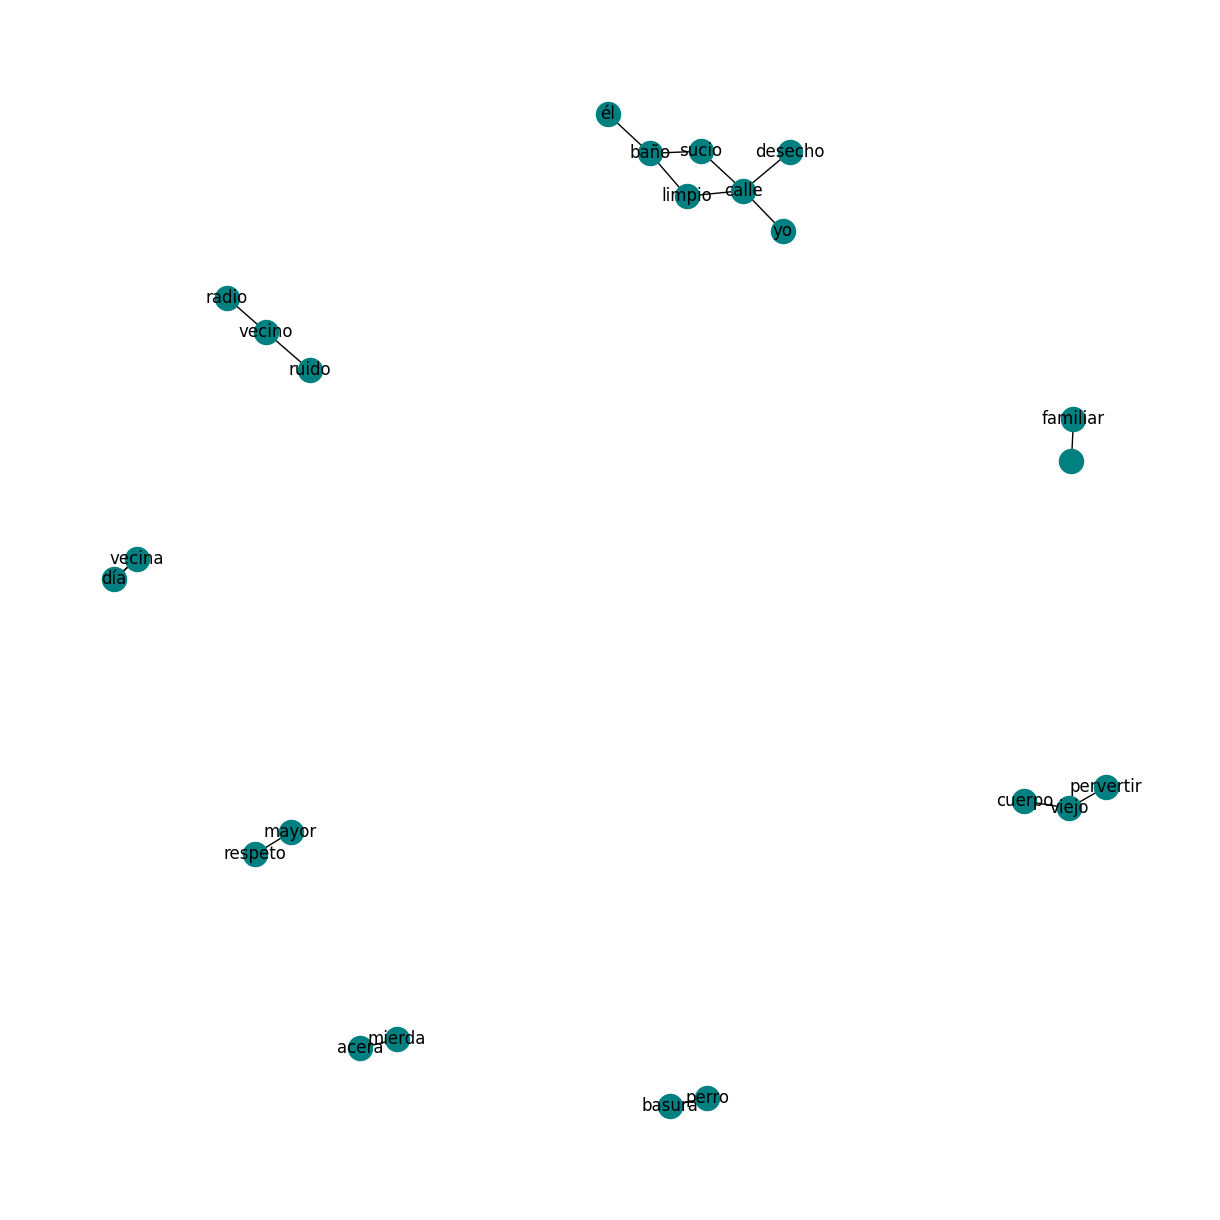

In [85]:
G = nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiGraph())
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='teal', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

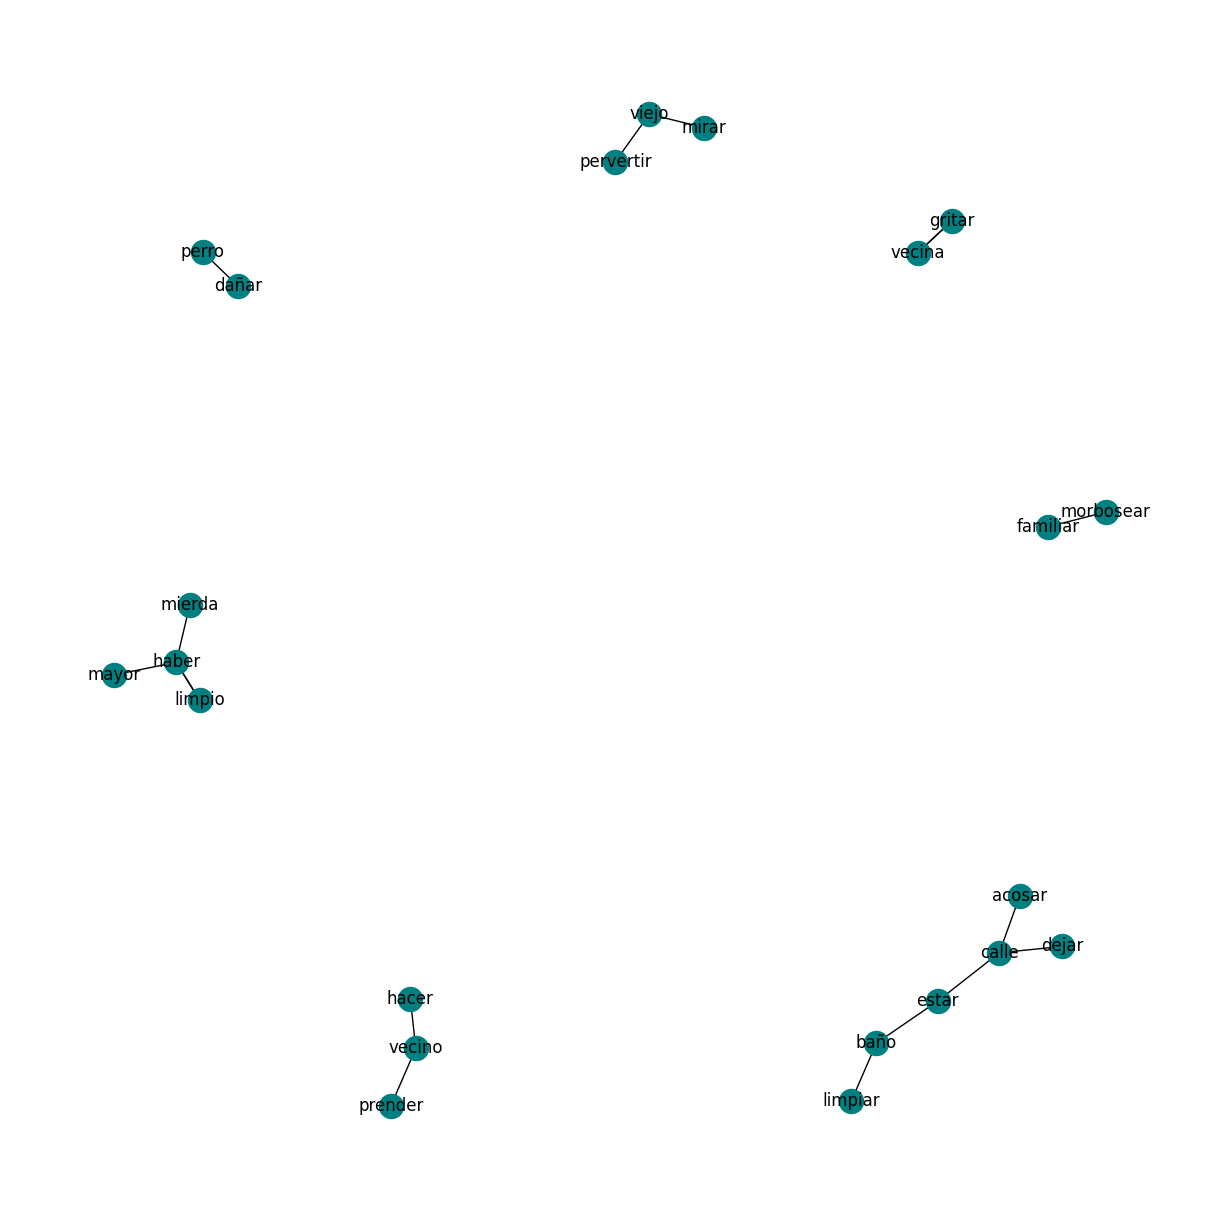

In [235]:
G = nx.from_pandas_edgelist(kg_df, "source", "edge", edge_attr=True, create_using=nx.MultiGraph())
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='teal', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [14]:
entities = []
actions = []

for index in range(0, len(source) - 1):
    if (source[index] != ""):
        actions.append(relations[index])
        entities.append(source[index])
    if (target[index] != ""):
        actions.append(relations[index])
        entities.append(target[index])

entities_actions_df = pd.DataFrame({'entities':entities, 'actions':actions, 'edge':actions})

In [15]:
entities_actions_df

,entities,actions,edge
0,limpio,haber,haber
1,baño,haber,haber
2,baño,limpiar,limpiar
3,él,limpiar,limpiar
4,baño,estar,estar
5,sucio,estar,estar
6,vecino,hacer,hacer
7,ruido,hacer,hacer
8,vecina,gritar,gritar
9,día,gritar,gritar


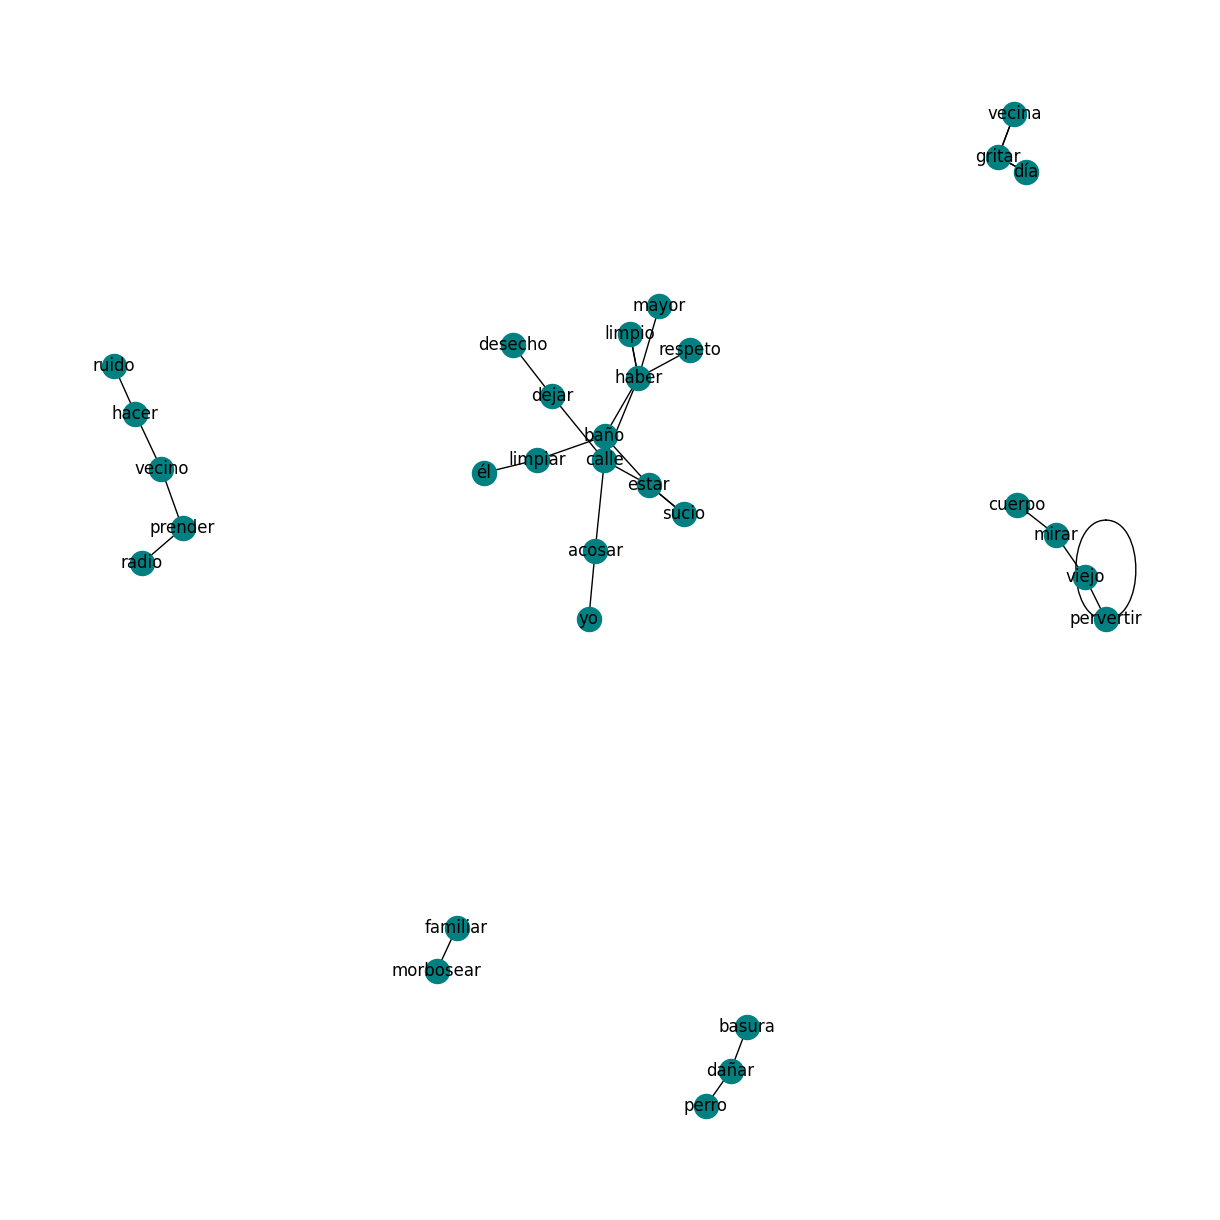

In [16]:
G = nx.from_pandas_edgelist(entities_actions_df, "entities", "actions", edge_attr=True, create_using=nx.MultiGraph())
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='teal', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

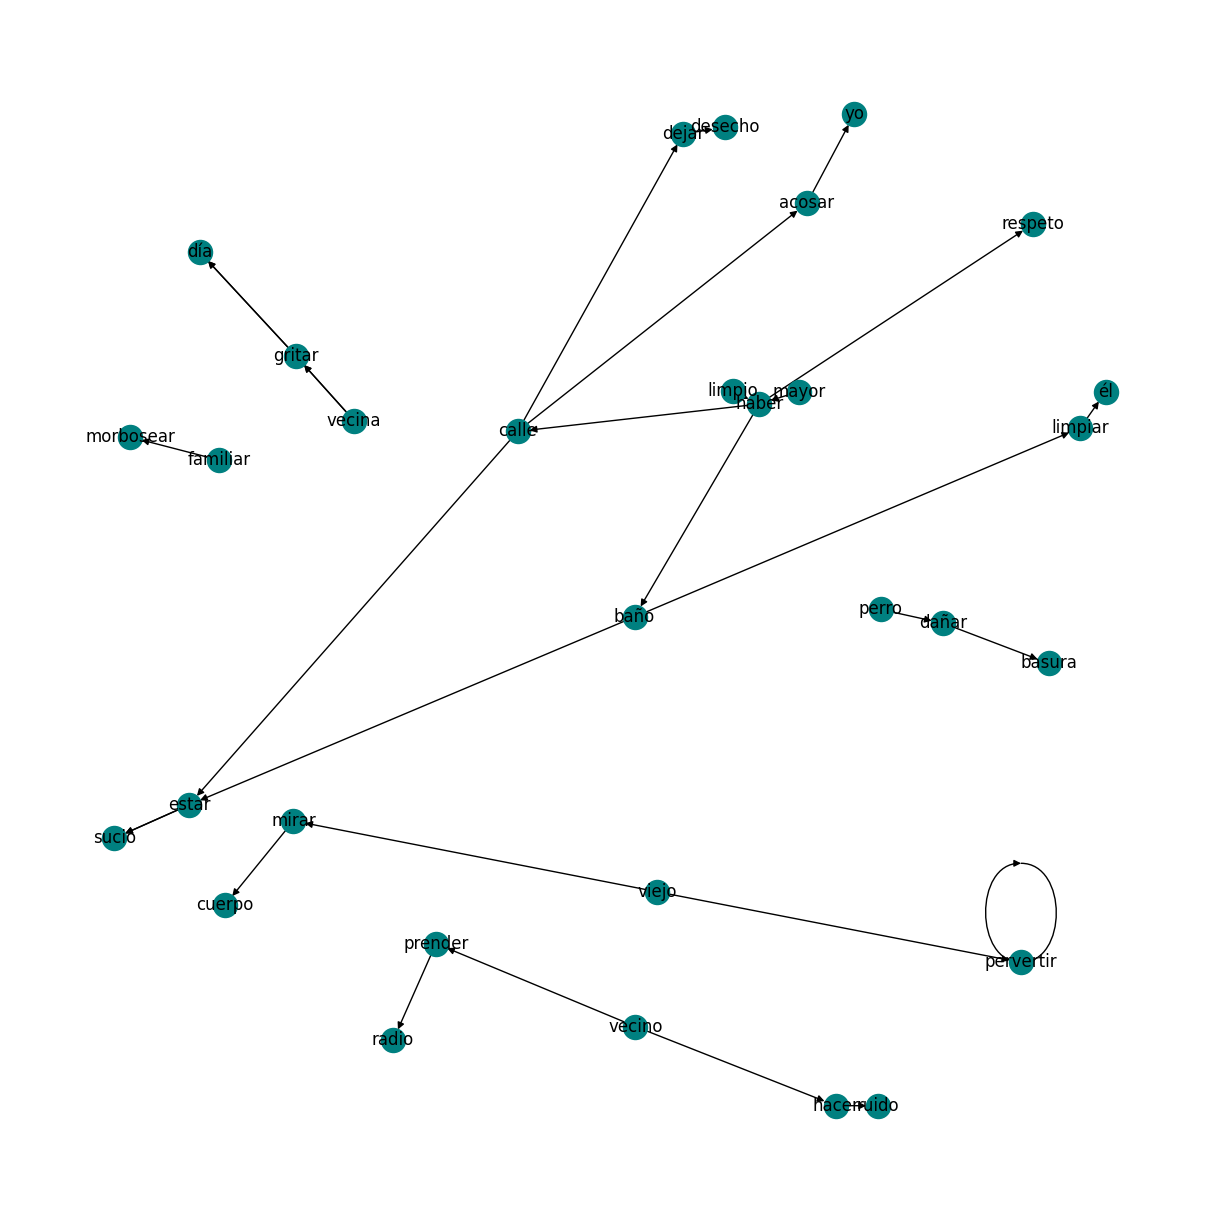

In [86]:
entities = []
actions = []

for index in range(0, len(source) - 1):
    if (source[index] != ""):
        actions.append(relations[index])
        entities.append(source[index])
    if (target[index] != ""):
        actions.append(target[index])
        entities.append(relations[index])

entities_actions_df = pd.DataFrame({'entities':entities, 'actions':actions, 'edge':actions})

G = nx.from_pandas_edgelist(entities_actions_df, "entities", "actions", edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='teal', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

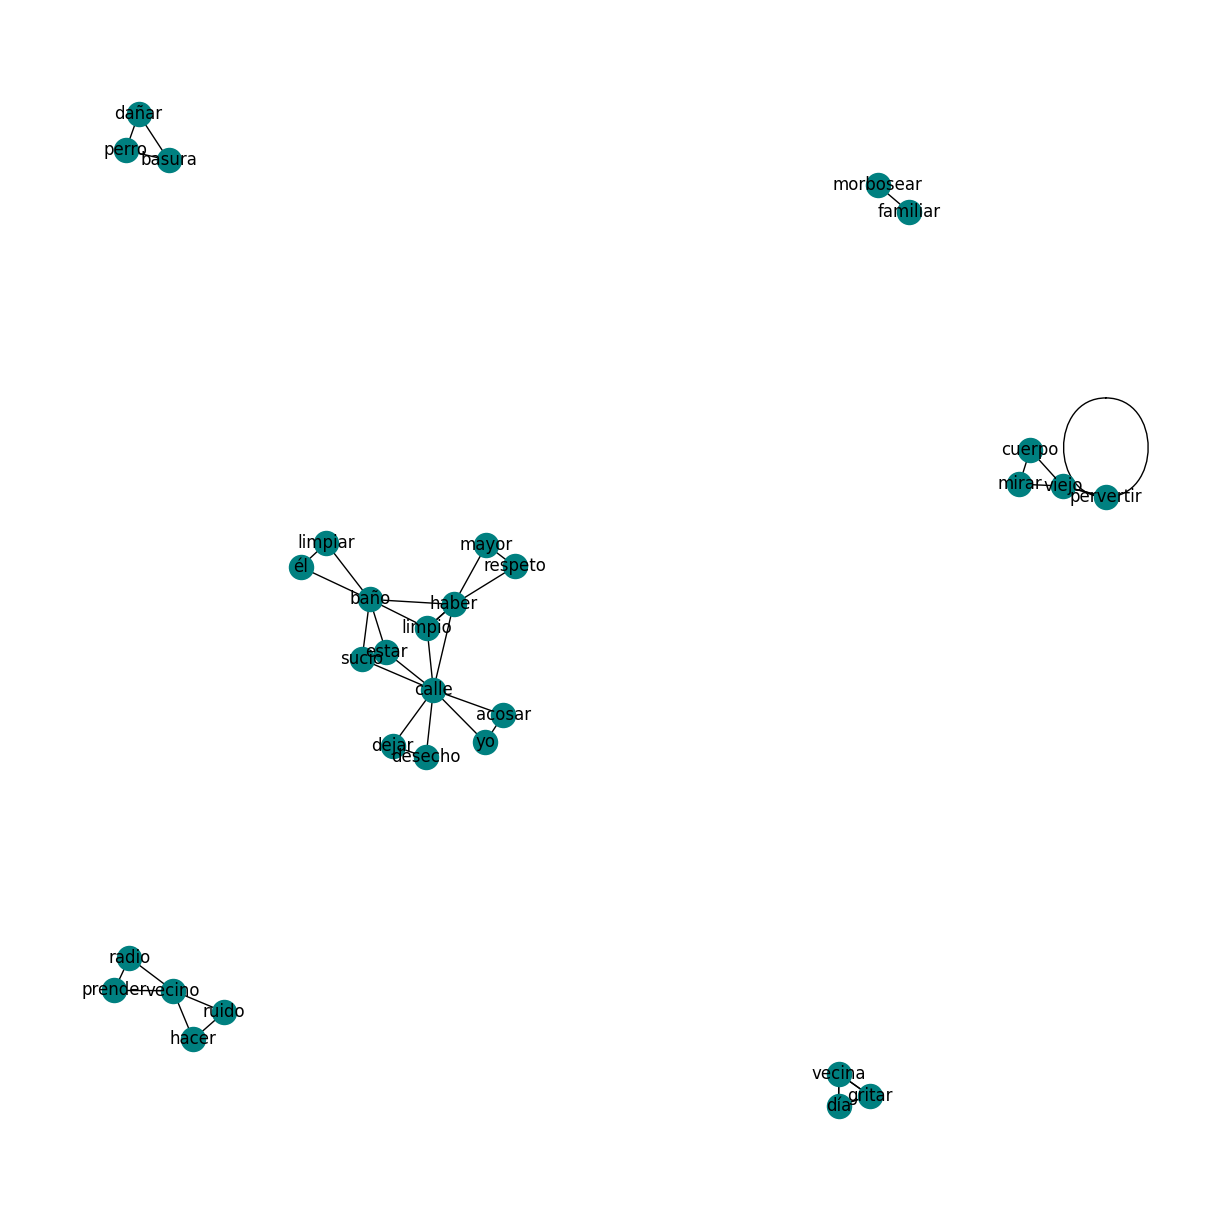

In [18]:
entities = []
actions = []

for index in range(0, len(source) - 1):
    if (source[index] != ""):
        actions.append(relations[index])
        entities.append(source[index])
    if (target[index] != ""):
        actions.append(target[index])
        entities.append(relations[index])
    if (source[index] != "" and target[index] != ""):
        actions.append(source[index])
        entities.append(target[index])

entities_actions_df = pd.DataFrame({'entities':entities, 'actions':actions, 'edge':actions})

G = nx.from_pandas_edgelist(entities_actions_df, "entities", "actions", edge_attr=True, create_using=nx.MultiGraph())
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='teal', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [19]:
entities = []
actions = []

for index in range(0, len(source) - 1):
    if (source[index] != ""):
        actions.append(relations[index])
        entities.append(source[index])
    if (target[index] != ""):
        actions.append(target[index])
        entities.append(relations[index])
    if (source[index] != "" and target[index] != ""):
        actions.append(source[index])
        entities.append(target[index])

entities_actions_df = pd.DataFrame({'entities':entities, 'actions':actions, 'edge':actions})

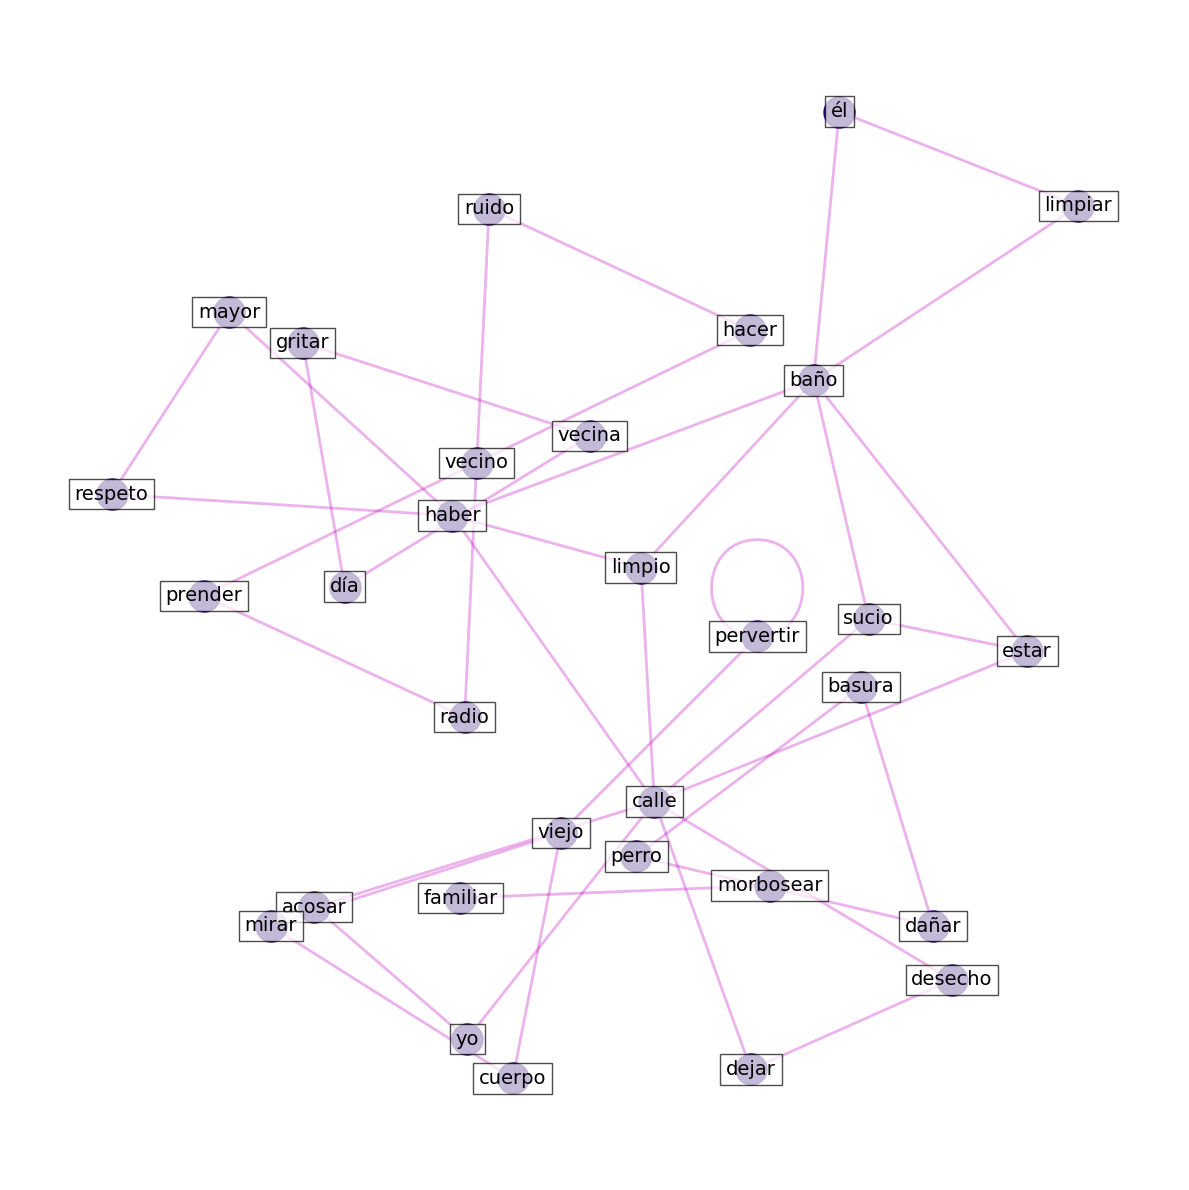

In [20]:
G = nx.MultiDiGraph()
for index in range(0, len(source) - 1):
    if (source[index] != ""):
        G.add_edge(source[index],relations[index])
    if (target[index] != ""):
        G.add_edge(target[index],relations[index])
    if (source[index] != "" and target[index] != ""):
        G.add_edge(source[index],target[index])

H = nx.Graph(G)
# edge width is proportional number of games played
#edgewidth = [len(G.get_edge_data(u, v)) for u, v in H.edges()]

pos = nx.kamada_kawai_layout(H)

fig, ax = plt.subplots(figsize=(12, 12))
# Visualize graph components
#nx.draw_networkx_edges(H, pos, alpha=0.3, width=edgewidth, edge_color="m")
nx.draw_networkx_edges(H, pos, alpha=0.3, width=2, edge_color="m")

#nx.draw_networkx_nodes(H, pos, node_size=nodesize, node_color="#210070", alpha=0.9)
nx.draw_networkx_nodes(H, pos, node_size=500, node_color="#210070", alpha=0.9)
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
nx.draw_networkx_labels(H, pos, font_size=14, bbox=label_options)

fig.tight_layout()
plt.axis("off")
plt.show()

In [4]:
from collections.abc import Iterable
from highcharts import Highchart
from IPython.core.display import HTML

In [71]:
%%javascript
require.config({
    packages: [{
        name: 'highcharts',
        main: 'highcharts'
    }],
    paths: {
        'highcharts': 'https://code.highcharts.com',
        'networkgraph': 'https://code.highcharts.com/modules/networkgraph.js'
    }
});

<IPython.core.display.Javascript object>

In [88]:
import json
from IPython.display import Javascript

chart_data = []

for index in range(0, len(source) - 1):
    if (source[index] != ""):
        chart_data.append([source[index], relations[index]])
    if (target[index] != ""):
        chart_data.append([target[index], relations[index]])
    if (source[index] != "" and target[index] != ""):
        chart_data.append([source[index], target[index]])

Javascript("window.chartData={};".format(json.dumps(chart_data)))

<IPython.core.display.Javascript object>

In [90]:
%%javascript
// Since I append the div later, sometimes there are multiple divs.
$("#container").remove();

// Make the cdiv to contain the chart.
element.append('<div id="container" style="min-width: 310px; min-height: 600px; margin: 0 auto"></div>');

console.log("init");
console.log(window.chartData);

// Require highcarts and make the chart.
require([
    'highcharts',
    'highcharts/modules/exporting',
    'highcharts/modules/accessibility',
    'highcharts/modules/networkgraph'
], function (Highcharts) {

    console.log("WORKING");
    $('#container').highcharts({
        chart: {
        type: 'networkgraph',
        height: '100%'
      },
      title: {
        text: 'The Indo-European Language Tree'
      },
      subtitle: {
        text: 'A Force-Directed Network Graph in Highcharts'
      },
      plotOptions: {
        networkgraph: {
          keys: ['from', 'to'],
          layoutAlgorithm: {
            enableSimulation: true,
            friction: -0.9
          }
        }
      },
      series: [{
        accessibility: {
          enabled: false
        },
        dataLabels: {
          enabled: true,
          linkFormat: ''
        },
        id: 'lang-tree',
        // This is where I used the chart_data from Python
        data: window.chartData
      }]
    });
});

<IPython.core.display.Javascript object>